# Welcome to SDGnE
---
SDGnE is a Python package designed for Synthetic Data Generation and Evaluation in Rare Event Prediction, offers a comprehensive system for your data needs.



## Notebook

In this notebook, we will compare the `Single Encoder Autoencoder` and the `SMOTE Algorithm` for synthetic data generation. We will generate synthetic data using both the algorithms and perform statistical evaluation.

# 0. Loading files
---

You can clone the package from GitHub/PyPi

In [ ]:
!pip install sdgne

We will use `gretel-client` to evaluate our results, so let's install it now.

In [ ]:
!pip install gretel-client

> Once cloned and installed, please re-start Google Colab

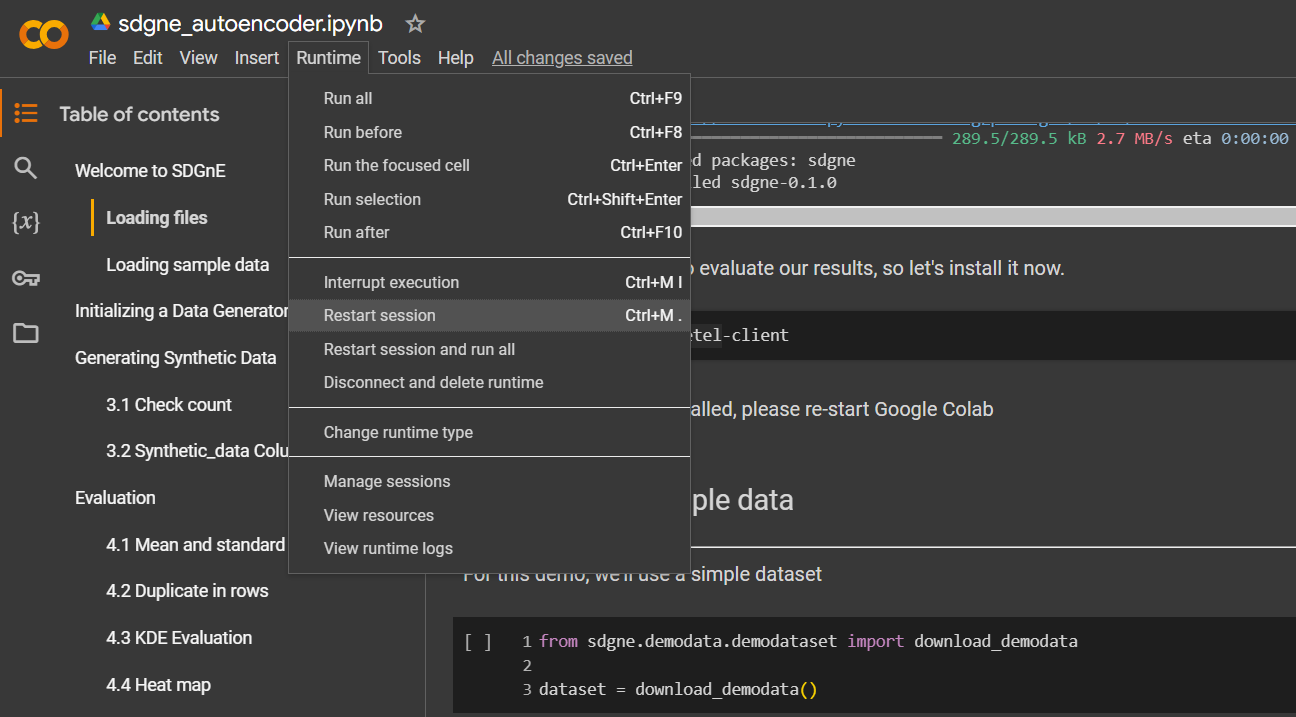

# 1. Loading sample data
---
For this demo, we'll use a simple dataset

In [3]:
from sdgne.demodata.demodataset import download_demodata

dataset = download_demodata()

ModuleNotFoundError: No module named 'sdgne'



*   The dataset consists of 25 rows and 4062 columns.
*   The `class` label is the output label consisting of values 1 or 0
*   In our dataset class label `0` is in minority.



We display the top 5 rows of dataset.

In [4]:
dataset.head()

,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,pm25diffin,pm10,pm25,...,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt,class
0,0.284,0.813,0.749,0.291,0.384,0.154,0.396,0.518,0.404,0.173,...,0.226,0.774,0.772,0.906,0.536,0.518,0.311,0.202,0.836,0
1,0.000,0.900,0.820,0.214,0.307,0.169,0.380,0.369,0.436,0.275,...,0.281,0.851,0.832,0.933,0.454,0.437,0.083,0.112,0.815,0
2,0.264,0.807,0.457,0.398,0.184,0.372,0.498,0.447,0.504,0.342,...,0.692,0.430,0.367,0.647,0.646,0.633,0.575,0.235,0.644,1
3,0.475,0.671,0.423,0.397,0.287,0.398,0.649,0.478,0.466,0.306,...,0.190,0.260,0.248,0.544,0.898,0.883,0.746,0.274,0.601,1
4,0.390,0.767,0.557,0.214,0.555,0.287,0.554,0.457,0.397,0.176,...,0.089,0.463,0.428,0.708,0.815,0.796,0.492,0.232,0.710,1


In [5]:
print('Imbalanced Ratio:')
class_counts = dataset['class'].value_counts()
class_counts_table = class_counts.reset_index()
class_counts_table.columns = ['Class', 'Sample_Count']
class_counts_table.style.hide(axis="index")

Imbalanced Ratio:


Class,Sample_Count
1,2925
0,1137


As shown above, class `0` has count of 1137 and is the minority class.

# 2. Initializing a Data Generator
---
In this demo, we would use the `Single Encoder Autoencoder` and the `SMOTE` class from *sdgne.datagenerator* to generate synthetic data.

We instantiate the class using `dataset` , `minority_column_label`, `minority_class_label`

*   minority_column_label:
    *   Column label of the class that you want to generate synthetic data for.

*   minority_class_label:
    *   Indicates the class for which minority data should be generated.

> *Note: For all available algorithms, please refer to the documentation.*



In [6]:
from sdgne.datagenerator.autoencoder import SingleEncoderAutoencoder
from sdgne.datagenerator.smote import SMOTE

minority_column_label = 'class'
minority_class_label = 0

autoencoder_synthesizer = SingleEncoderAutoencoder(dataset,
                               minority_column_label,
                               minority_class_label
                               )

smote_synthesizer = SMOTE(dataset,
                    minority_column_label,
                    minority_class_label
                    )

# 3. Generating Synthetic Data
---
Now we use the synthesizer object to generate syntehtic data for the minority class and append it to original dataframe.

In [7]:
autoencoder_synthesized_data = autoencoder_synthesizer.data_generator()
smote_synthesized_data = smote_synthesizer.data_generator()

## 3.1 Check count

After we generate `synthesized_data`, now lets check the class count.

In [8]:
print('Balanced Ratio:')
class_counts1 = autoencoder_synthesized_data['class'].value_counts()
class_counts_table1 = class_counts1.reset_index()
class_counts_table1.columns = ['Class', 'Sample_Count']
class_counts_table1.style.hide(axis="index")

class_counts2 = smote_synthesized_data['class'].value_counts()
class_counts_table2 = class_counts2.reset_index()
class_counts_table2.columns = ['Class', 'Sample_Count']
class_counts_table2.style.hide(axis="index")

Balanced Ratio:


Class,Sample_Count
1,2925
0,1137


## 3.2 Saving Dataset

To use the new dataset, you can simply save it as below.

In [9]:
autoencoder_synthesized_data.to_csv('autoencoder_synthesized_data.csv')
smote_synthesized_data.to_csv('smote_synthesized_data.csv')

# 4. Evaluation
---
We have added few functions to evaluate the quality of synthetic data and provide a comparative study.

The evaluation functions can be invoked by creating an instance of `Evaluation`

In [10]:
from sdgne.evaluator.evaluator import Evaluation
from tabulate import tabulate


minority_column_label = 'class'
minority_class_label = 0

autoencoder_evaluator = Evaluation(autoencoder_synthesized_data,
                  minority_column_label,
                  minority_class_label
                  )

smote_evaluator = Evaluation(smote_synthesized_data,
                  minority_column_label,
                  minority_class_label
                  )

## 4.1 Mean and standard deviation

The below function helps us calculate the mean and standard deviation for the real minority and the synthetic minority class. For our algorithm comparasion, we display the averaged (over all columns) standard deviation for the syntehtic minority data calculated for both algorithms.

In [11]:
autoencoder_stats = autoencoder_evaluator.mean_and_std()
smote_stats = smote_evaluator.mean_and_std()

In [12]:
autoencoder_std_mean = autoencoder_stats['Std_synthetic_minority_data'].mean()
smote_std_mean = smote_stats['Std_synthetic_minority_data'].mean()

deviation_table = [
    ["Algorithm", "Average Deviation"],
    ["Autoencoder", autoencoder_std_mean],
    ["SMOTE", smote_std_mean]
]
print(tabulate(deviation_table, headers="firstrow"))

Algorithm      Average Deviation
-----------  -------------------
Autoencoder             0.209316
SMOTE                   0.214859


## 4.2 Percent Change in Mean

Below, we calculate the percentage change in means of original minority data and the synthetic minority data. We calculate this change for both the algorithms.

In [13]:
autoencoder_mean_original = autoencoder_stats['Mean_original_minority_data'].mean()
autoencoder_mean_synthetic = autoencoder_stats['Mean_synthetic_minority_data'].mean()
autoencoder_percent_change = ((autoencoder_mean_synthetic - autoencoder_mean_original) / autoencoder_mean_original) * 100

smote_mean_original = smote_stats['Mean_original_minority_data'].mean()
smote_mean_synthetic = smote_stats['Mean_synthetic_minority_data'].mean()
smote_percent_change = ((smote_mean_synthetic - smote_mean_original) / smote_mean_original) * 100

percentage_change_table = [
    ["Algorithm", "% Change"],
    ["Autoencoder", f"{autoencoder_percent_change:.2f}%"],
    ["SMOTE", f"{smote_percent_change:.2f}%"]
]

print(tabulate(percentage_change_table, headers="firstrow"))

Algorithm    % Change
-----------  ----------
Autoencoder  -0.61%
SMOTE        -0.30%


Thus, we can see that the average percentage change of mean for synthethetic data generated for all columns was smaller when we used SMOTE.

## 4.3 Kullback-Leibler (KL) divergence

 Kullback-Leibler (KL) divergence is a measure of how one probability distribution diverges from a second, expected probability distribution. In simple terms, it quantifies the difference between two probability distributions.

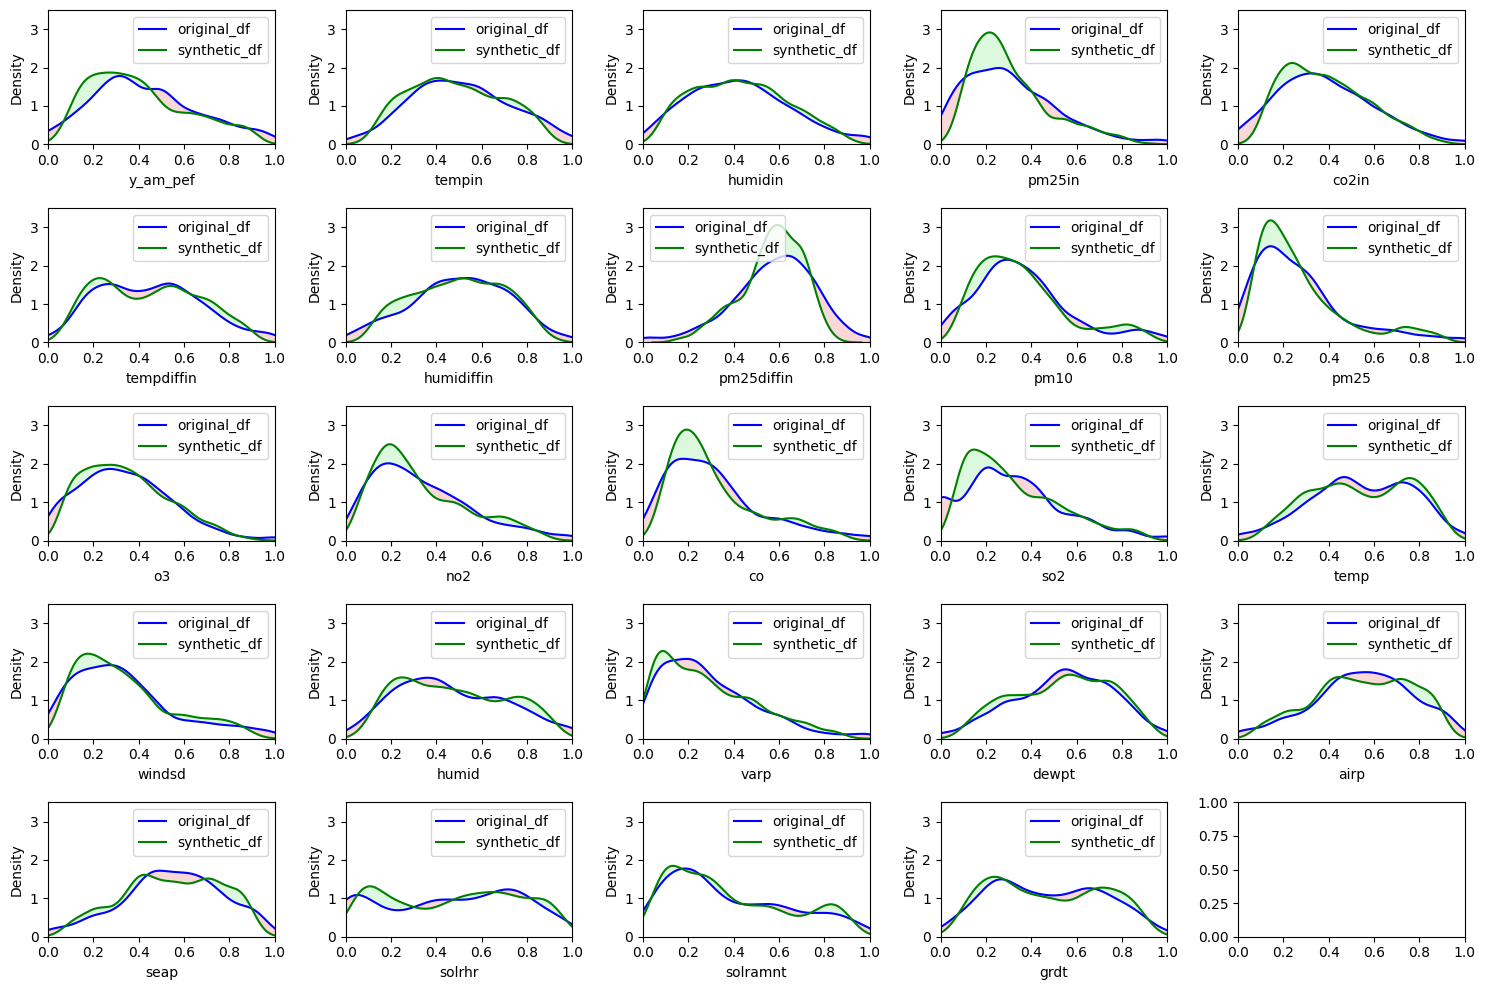

In [14]:
autoencoder_plot, autoencoder_column_details, autoencoder_total_highlighted_area, autoencoder_total_kl_divergence, autoencoder_average_kl_divergence = autoencoder_evaluator.plot_kde_density_graph()


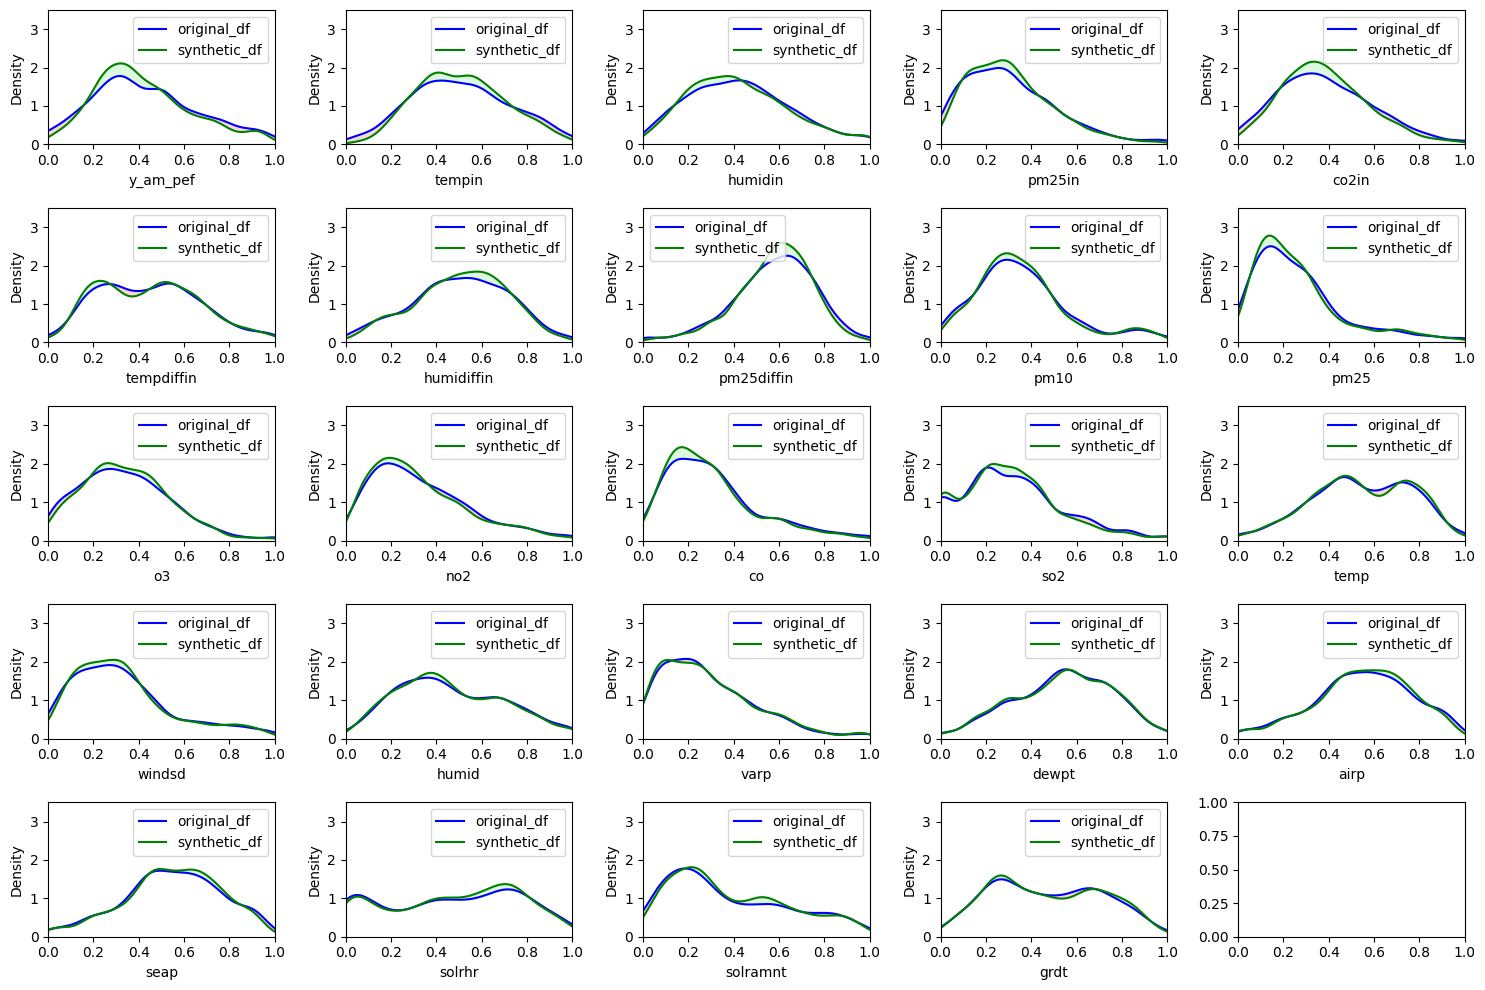

In [15]:
smote_plot, smote_column_details, smote_total_highlighted_area, smote_total_kl_divergence, smote_average_kl_divergence = smote_evaluator.plot_kde_density_graph()

Displaying Total KL Divergence

In [16]:
total_kl_divergence_table = [
    ["Algorithm", "Total KL Divergence"],
    ["Autoencoder", autoencoder_total_kl_divergence],
    ["SMOTE", smote_total_kl_divergence]
]
print(tabulate(total_kl_divergence_table, headers="firstrow"))

Algorithm      Total KL Divergence
-----------  ---------------------
Autoencoder               1.03985
SMOTE                     0.121582


Displaying the average KL divergence for each algorithm calculated over all columns.

In [ ]:
avg_kl_divergence_table = [
    ["Algorithm", "Average KL Divergence"],
    ["Autoencoder", autoencoder_total_kl_divergence],
    ["SMOTE", smote_total_kl_divergence]
]
print(tabulate(avg_kl_divergence_table, headers="firstrow"))

Algorithm      Average KL Divergence
-----------  -----------------------
Autoencoder                 1.03985
SMOTE                       0.144611


## 4.4 Gretel Evaluation

Gretel is a online platform to genereate synthetic data using different algorithms. They also provide an easy to use evalaution metrics. We use the gretel score as an additional evaluation metrics.

Please refer to: [gretel.ai](https://gretel.ai/evaluate)



In [ ]:
from sdgne.evaluator.evaluator import GretelEvaluation

To calculate `raw_score` and the `grade` of the synthetic dataset, you'd need to get the GRETEL_API_KEY. Which you can get from [here.](https://console.gretel.ai/users/me/key)

In [ ]:
GRETEL_API_KEY = 'GRETEL_API_KEY'
autoencoder_gretel_evaluator = GretelEvaluation(autoencoder_synthesized_data,
                        minority_column_label,
                        minority_class_label,
                        GRETEL_API_KEY)

smote_gretel_evaluator = GretelEvaluation(smote_synthesized_data,
                        minority_column_label,
                        minority_class_label,
                        GRETEL_API_KEY)

We run the `run_gretel_quality_report` function that returns the Gretel_report

In [ ]:
autoencoder_gretel_score = autoencoder_gretel_evaluator.run_gretel_quality_report()
smote_gretel_score = smote_gretel_evaluator.run_gretel_quality_report()

print(autoencoder_gretel_score['Acknowledgement'])
print("Autoencoder Gretel Score: ",autoencoder_gretel_score['Gretel_report'] )
print("SMOTE Gretel Score: ", smote_gretel_score['Gretel_report'])

This is a quality report for the synthetic data generated by Gretel AI. Please refer to https://gretel.ai/ for complete documentation
Autoencoder Gretel Score:  {'raw_score': 83.89629629629628, 'grade': 'Excellent', 'score': 83}
SMOTE Gretel Score:  {'raw_score': 92.57777777777777, 'grade': 'Excellent', 'score': 92}


# 5. References
---
- Bae, W.D., Alfonso, A., Stanko, D., Hao, L., Le, L., Horak, M.: Improving classification performance on rare events in data starved medical applications. In: 2023 IEEE
International Symposium on Medical Measurements and Applications (MeMeA).
pp. 1–6. IEEE (2023)

- Chawla, N.V., Bowyer, K.W., Hall, L.O., Kegelmeyer, W.P.: Smote: synthetic minority over-sampling technique. Journal of artificial intelligence research 16, 321–357
(2002)

- Gretel: Gretel (Accessed: January, 2024), https://gretel.ai/.

- Huang, Y., Fields, K.G., Ma, Y.: A tutorial on generative adversarial networks
with application to classification of imbalanced data. Statistical Analysis and Data
Mining: The ASA Data Science Journal (2021)

- Kamalov, F., Denisov, D.: Gamma distribution-based sampling for imbalanced data.
Knowledge-Based Systems 207, 106368 (2020)

- Lee, H., Kim, J., Kim, S.: Gaussian-based smote algorithm for solving skewed class
distributions. International Journal of Fuzzy Logic and Intelligent Systems 17(4),
229–234 (2017)

- Wan, Q., Deng, X., Li, M., Yang, H.: Sddsmote: Synthetic minority oversampling
technique based on sample density distribution for enhanced classification on imbalanced microarray data. In: The 6th International Conf. on Compute and Data
Analysis. pp. 35–42 (2022)

- Woo, J., Rudasingwa, G., Kim, S.: Assessment of daily personal pm2. 5 exposure
level according to four major activities among children. Applied Sciences 10(1), 159
(2020)

- Xu, L., Skoularidou, M., Cuesta-Infante, A., Veeramachaneni, K.: Modeling tabular
data using conditional gan. Advances in neural information processing systems 32
(2019)
